In [1]:
import time
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import cohen_kappa_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import mode
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings("ignore")


<div style="display:fill;
           border-radius:5px;
           background-color: lightblue;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 10px;
              color:black;">
    Alright! So Playground Series huh... ^_^ So exciting!!! I believe these competitions are a great break for me from the other competitions and a nice avenue to chill and write up some structured codes to help others get their feet wet in this field of machine learning. I remember when I first started on Kaggle, I was afraid of competitions and didn't even know where to start. So for all of those other people out there, I hope what I wrote can give you an idea of how to approach a competition and give you some inspiration and ideas! 
</p>
</div>

<div style="display:fill;
           border-radius:5px;
           background-color: lightblue;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    I was also very much inspired from some of the other notebooks out there, so feel free to take a look at these too! 
</p>
<ul>
    <li>https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382698</li>
    <li>https://www.kaggle.com/code/odins0n/playground-s-3-e-5-eda-modelling/comments</li>
</div>

# Let's Start!!!

In [2]:
"""train = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv').drop('Id',axis=1)
#combine with original training set
orig_train = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv').drop('Id',axis=1)
#combine with original training set
orig_train = orig_train[~orig_train.duplicated()]
train = pd.concat([train,orig_train]).reset_index(drop=True)
train['istest']= 0
test = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv').drop('Id',axis=1)
test['istest'] = 1
raw = pd.concat([train,test]).reset_index(drop=True)
sub = pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')"""

"train = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv').drop('Id',axis=1)\n#combine with original training set\norig_train = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv').drop('Id',axis=1)\n#combine with original training set\norig_train = orig_train[~orig_train.duplicated()]\ntrain = pd.concat([train,orig_train]).reset_index(drop=True)\ntrain['istest']= 0\ntest = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv').drop('Id',axis=1)\ntest['istest'] = 1\nraw = pd.concat([train,test]).reset_index(drop=True)\nsub = pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')"

In [3]:
# Importing datasets

train = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv').drop('Id',axis=1)
test = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv').drop('Id',axis=1)
sub = pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')
original = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')

train['istest'] = 0
original['istest'] = 0
test['istest'] = 1

raw = pd.concat([train,test,original]).reset_index(drop=True)

# A peak at the data

In [4]:
raw

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,istest,Id
0,8.0,0.500,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6.0,0,NaN
1,9.3,0.300,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6.0,0,NaN
2,7.1,0.510,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7.0,0,NaN
3,8.1,0.870,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5.0,0,NaN
4,8.5,0.360,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4566,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,0,1592.0
4567,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6.0,0,1593.0
4568,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,0,1594.0
4569,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0,0,1595.0


In [5]:
target = 'quality'
features = list(raw.columns[:-3])

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4571 entries, 0 to 4570
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4571 non-null   float64
 1   volatile acidity      4571 non-null   float64
 2   citric acid           4571 non-null   float64
 3   residual sugar        4571 non-null   float64
 4   chlorides             4571 non-null   float64
 5   free sulfur dioxide   4571 non-null   float64
 6   total sulfur dioxide  4571 non-null   float64
 7   density               4571 non-null   float64
 8   pH                    4571 non-null   float64
 9   sulphates             4571 non-null   float64
 10  alcohol               4571 non-null   float64
 11  quality               3199 non-null   float64
 12  istest                4571 non-null   int64  
 13  Id                    1143 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 500.1 KB


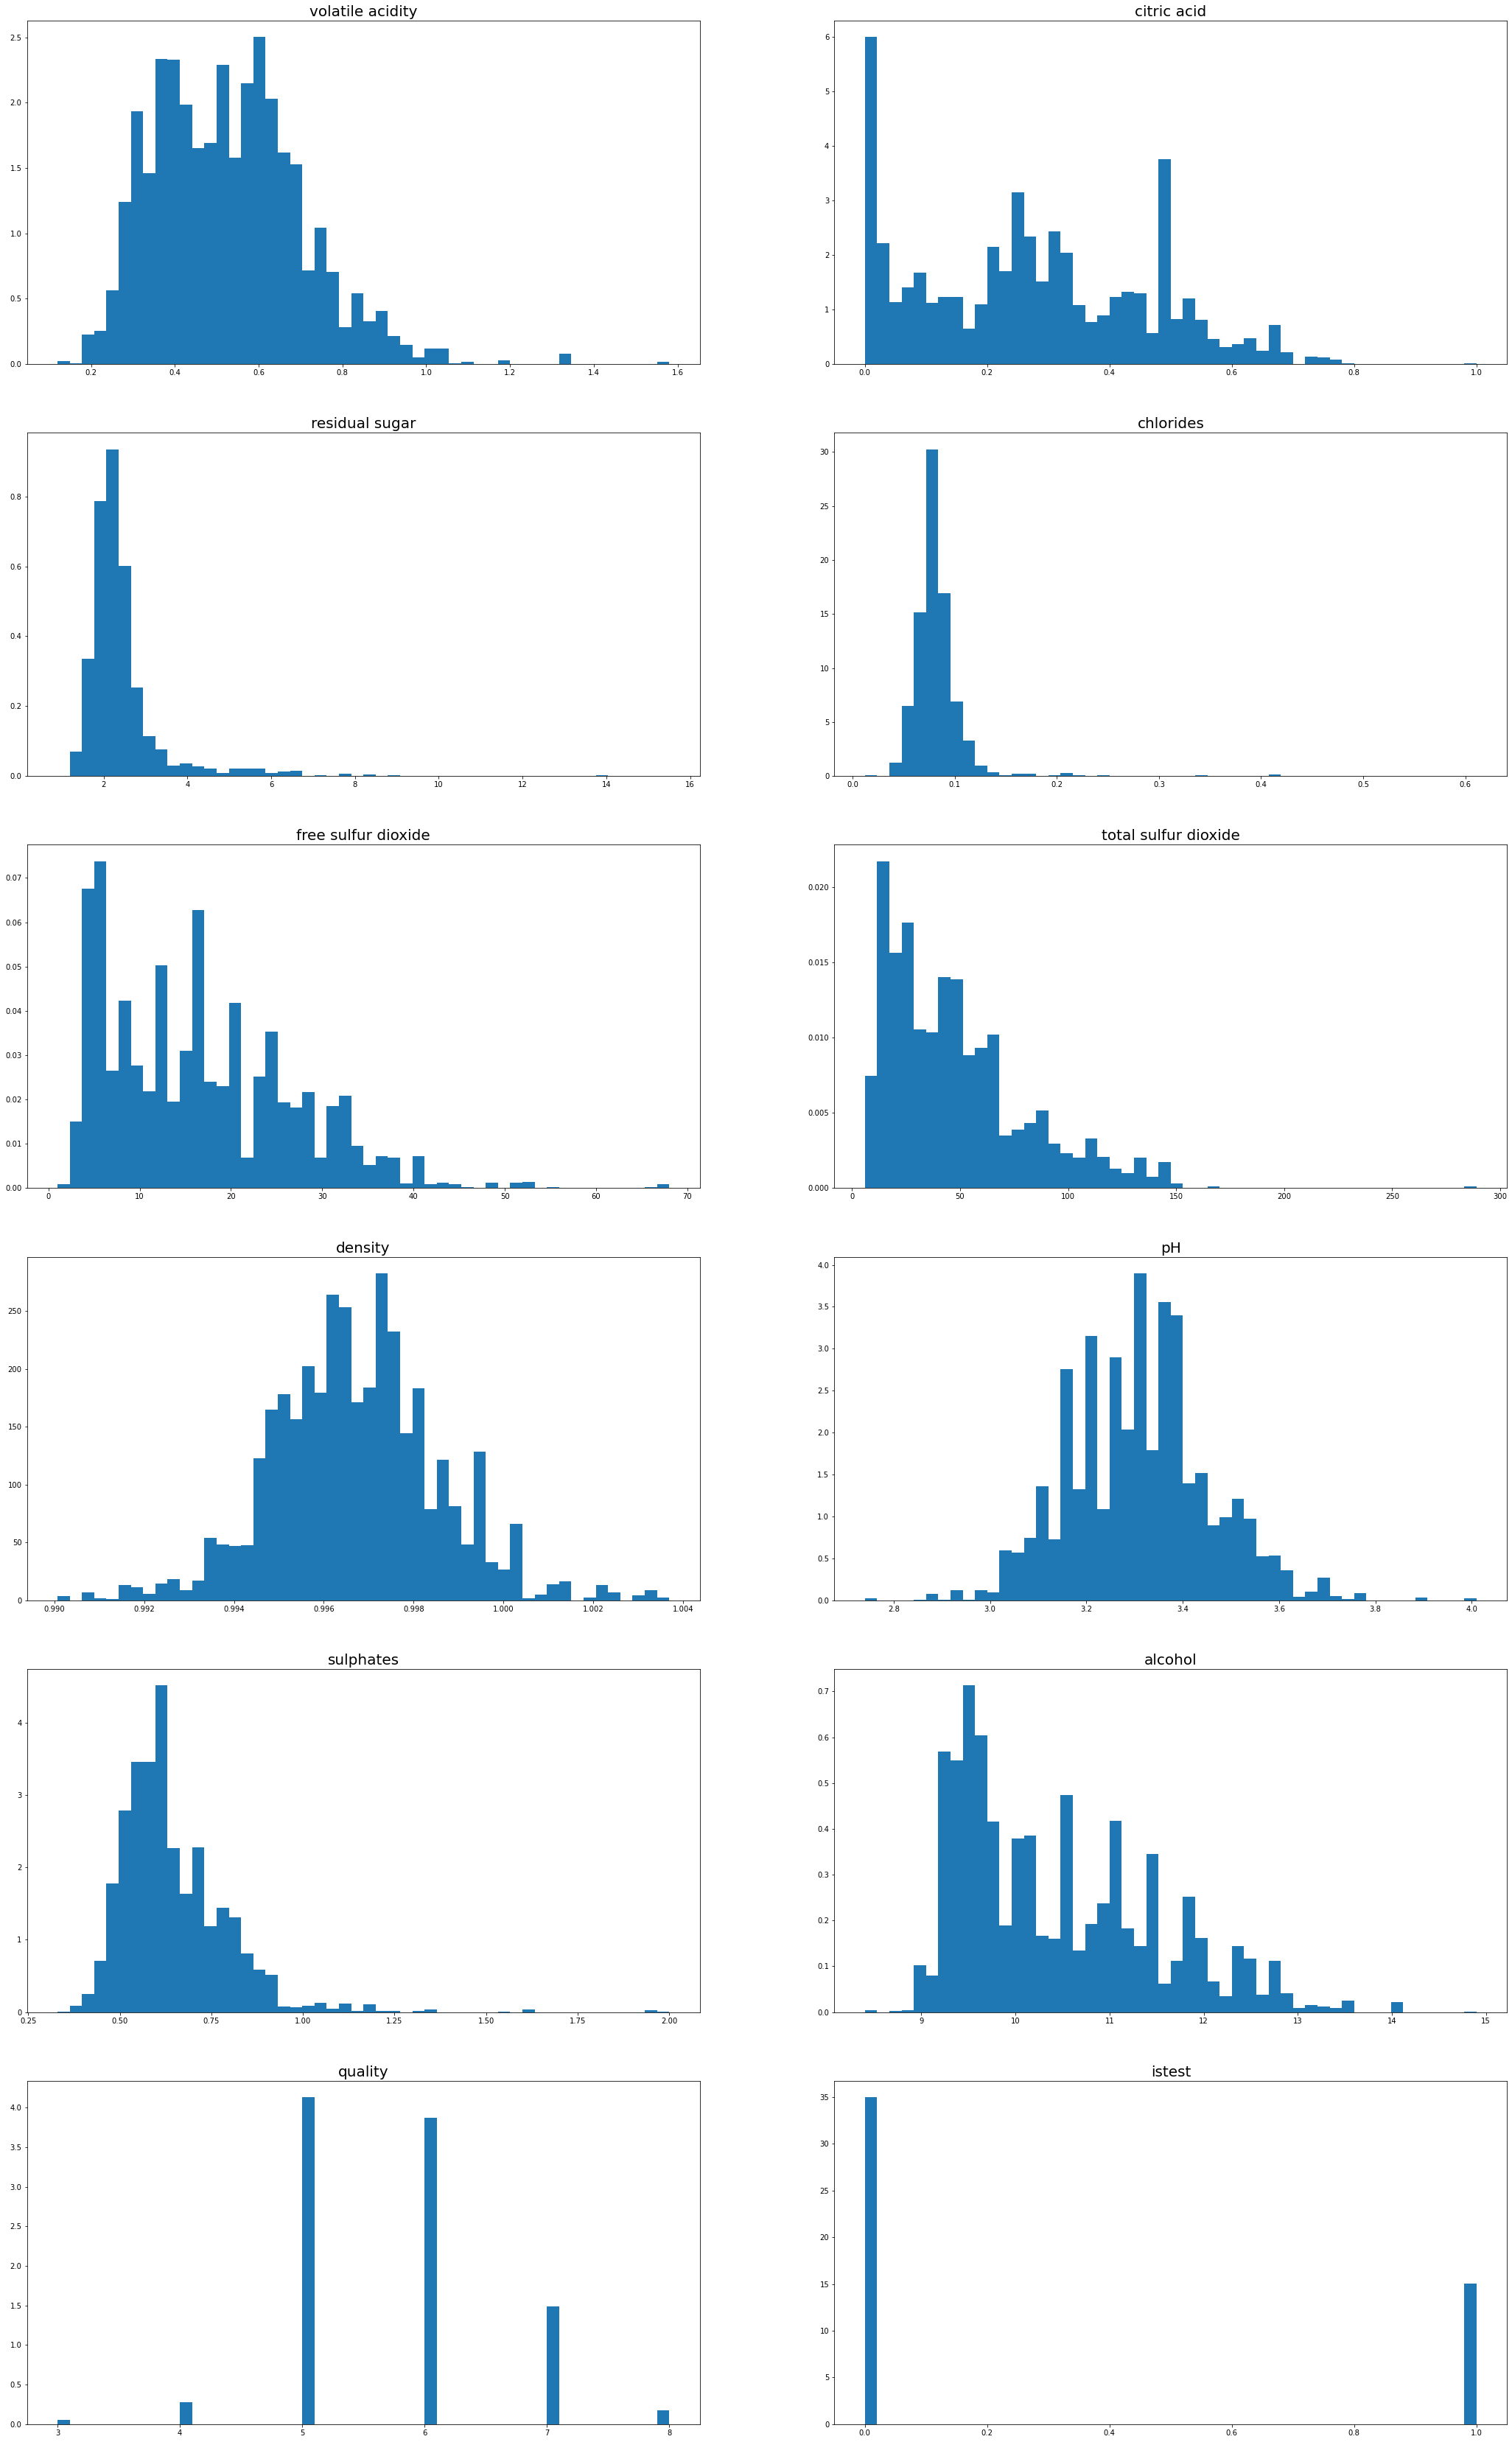

In [7]:
tmp = list(train.columns[1:])
fig, axs = plt.subplots(6, 2)
fig.set_size_inches(36, 60)
for r in range(6):
    for c in range(2):
        axs[r, c].hist(raw[tmp[2*r+c]], bins=50, density=True, log=False)
        axs[r, c].set_title(f'{tmp[2*r+c]}', fontsize=20)

#### fixed acidity, alcohol, total sulfur dioxide look like they are skewed

### Let's attempt to **normalize** these skewed data

In [8]:
powertransform_raw = raw.copy()

In [9]:
pt = PowerTransformer()
for f in ['fixed acidity', 'alcohol', 'total sulfur dioxide', 'free sulfur dioxide']:
    powertransform_raw[f] = pt.fit_transform(np.array(powertransform_raw[f]).reshape(-1,1))

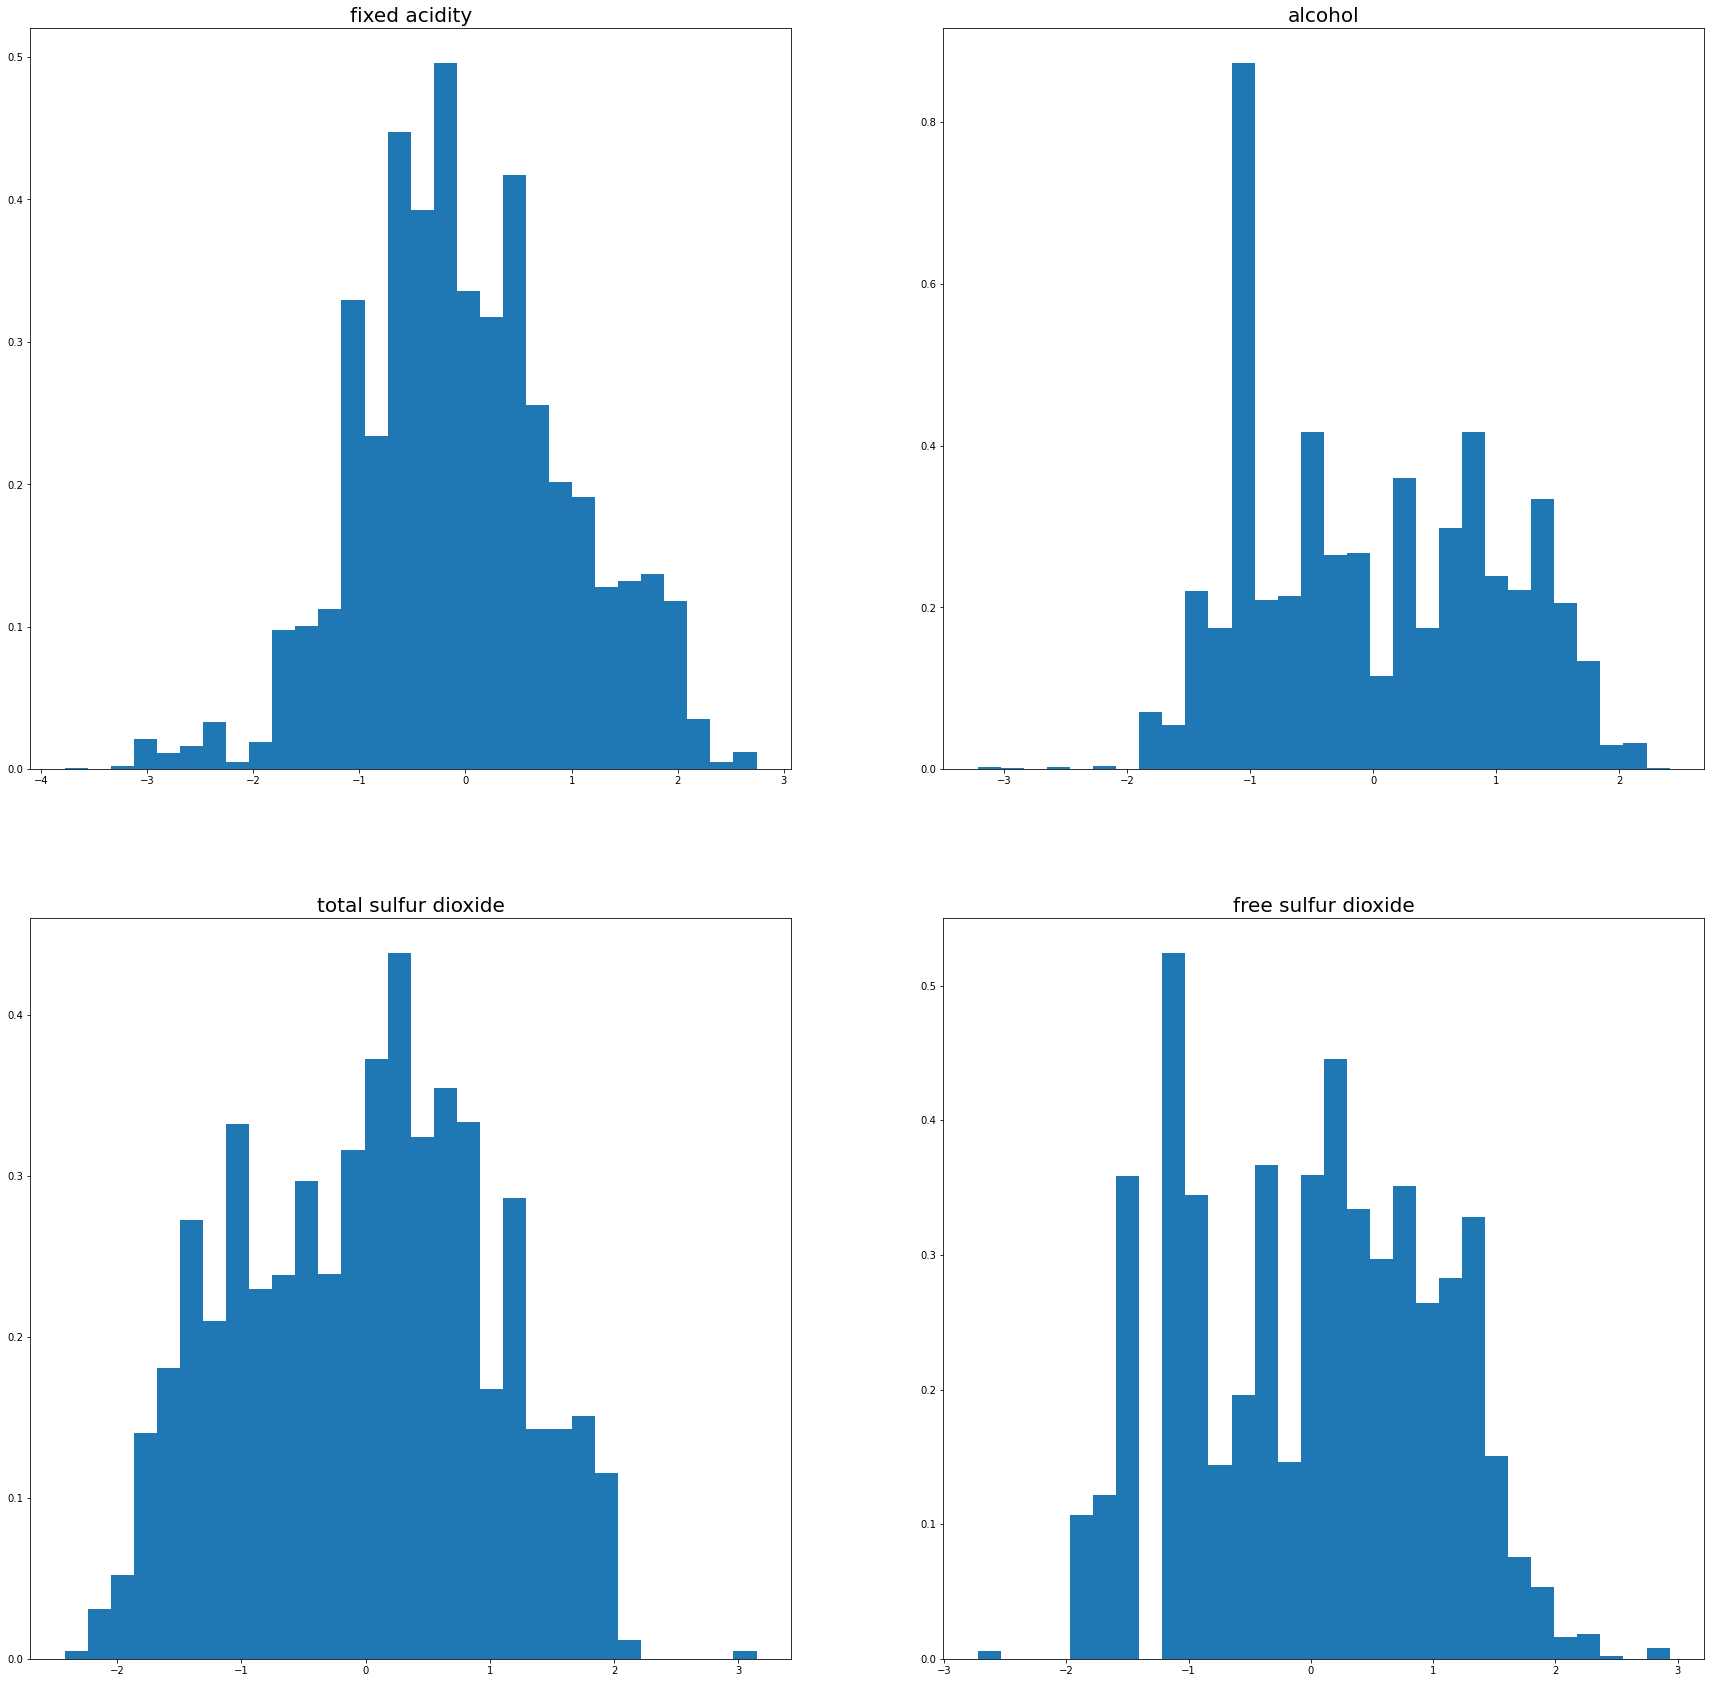

In [10]:
tmp = ['fixed acidity', 'alcohol', 'total sulfur dioxide', 'free sulfur dioxide']
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(30, 30)
for r in range(2):
    for c in range(2):
        axs[r, c].hist(powertransform_raw[tmp[2*r+c]], bins=30, density=True, log=False)
        axs[r, c].set_title(f'{tmp[2*r+c]}', fontsize=20)

#### These definitely look better now.

### Let's try **standardizing** the data

In [11]:
standardize_raw = raw.copy()

In [12]:
scaler = preprocessing.StandardScaler()
for f in features:
    standardize_raw[f] = scaler.fit_transform(np.array(standardize_raw[f]).reshape(-1, 1))

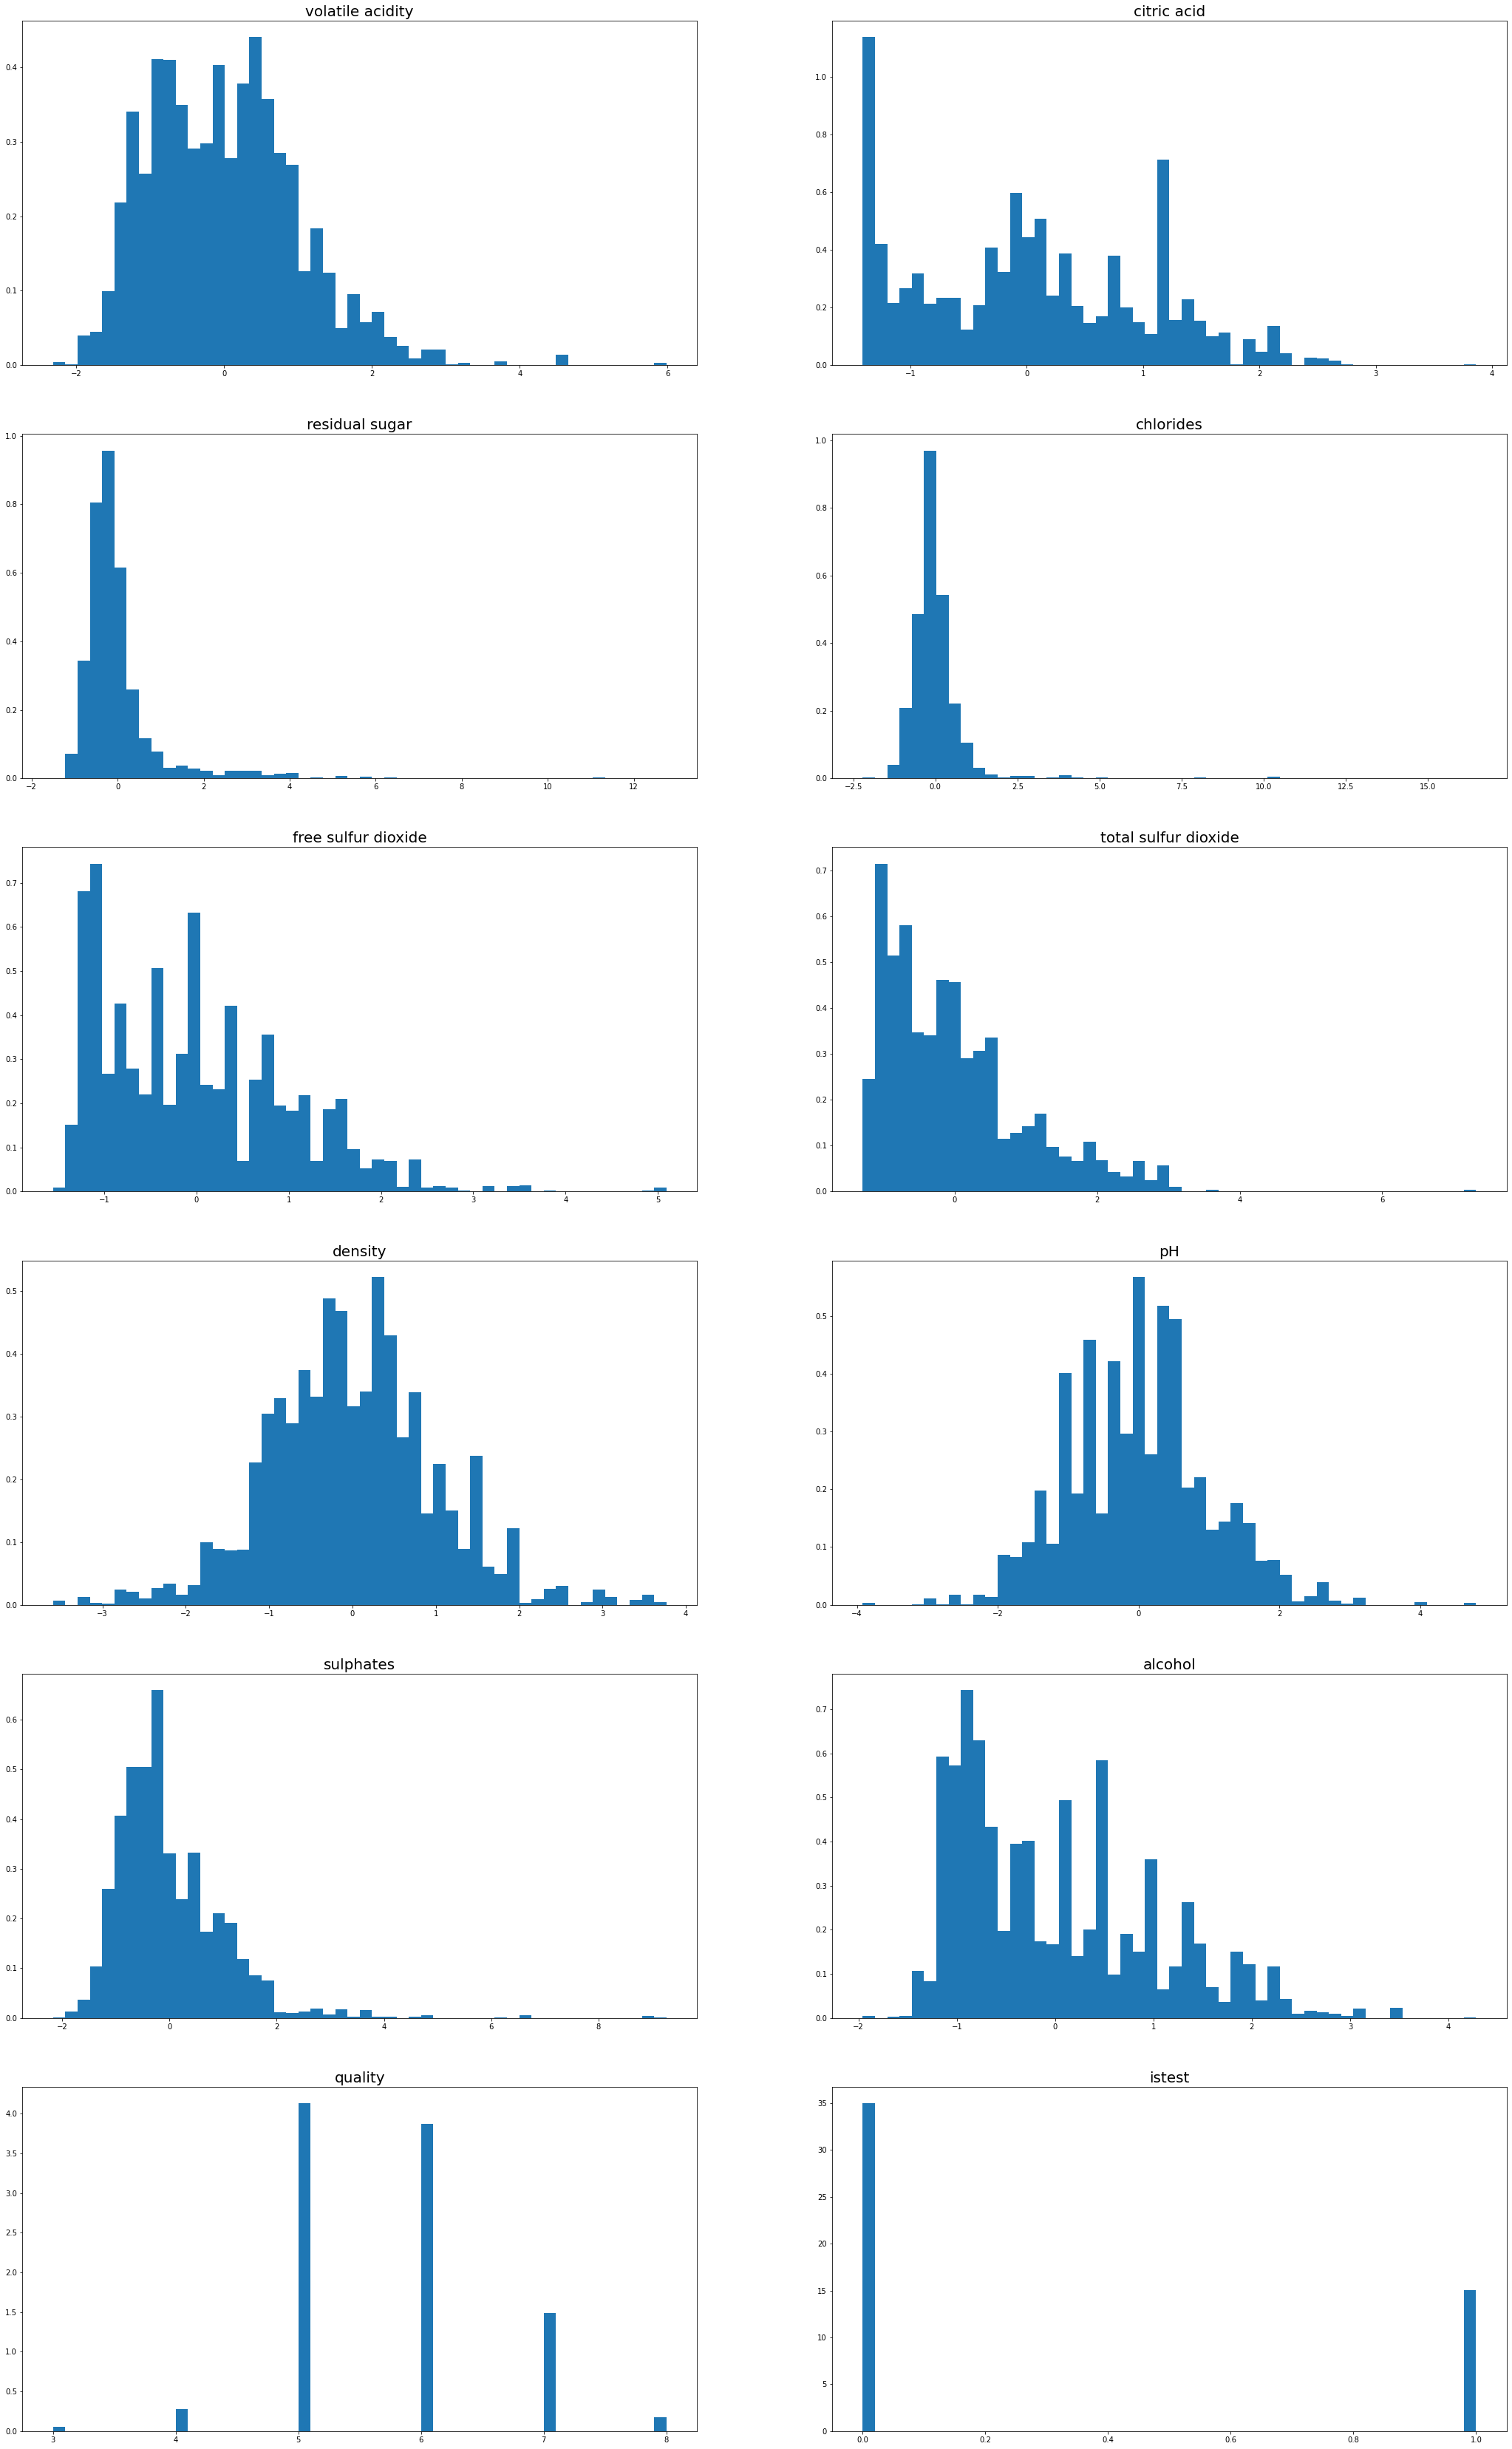

In [13]:
tmp = list(train.columns[1:])
fig, axs = plt.subplots(6, 2)
fig.set_size_inches(36, 60)
for r in range(6):
    for c in range(2):
        axs[r, c].hist(standardize_raw[tmp[2*r+c]], bins=50, density=True, log=False)
        axs[r, c].set_title(f'{tmp[2*r+c]}', fontsize=20)

### Ok so let us powertransform the troublesome features, and then apply standardization to all of the features. 

# Feature Adjustments

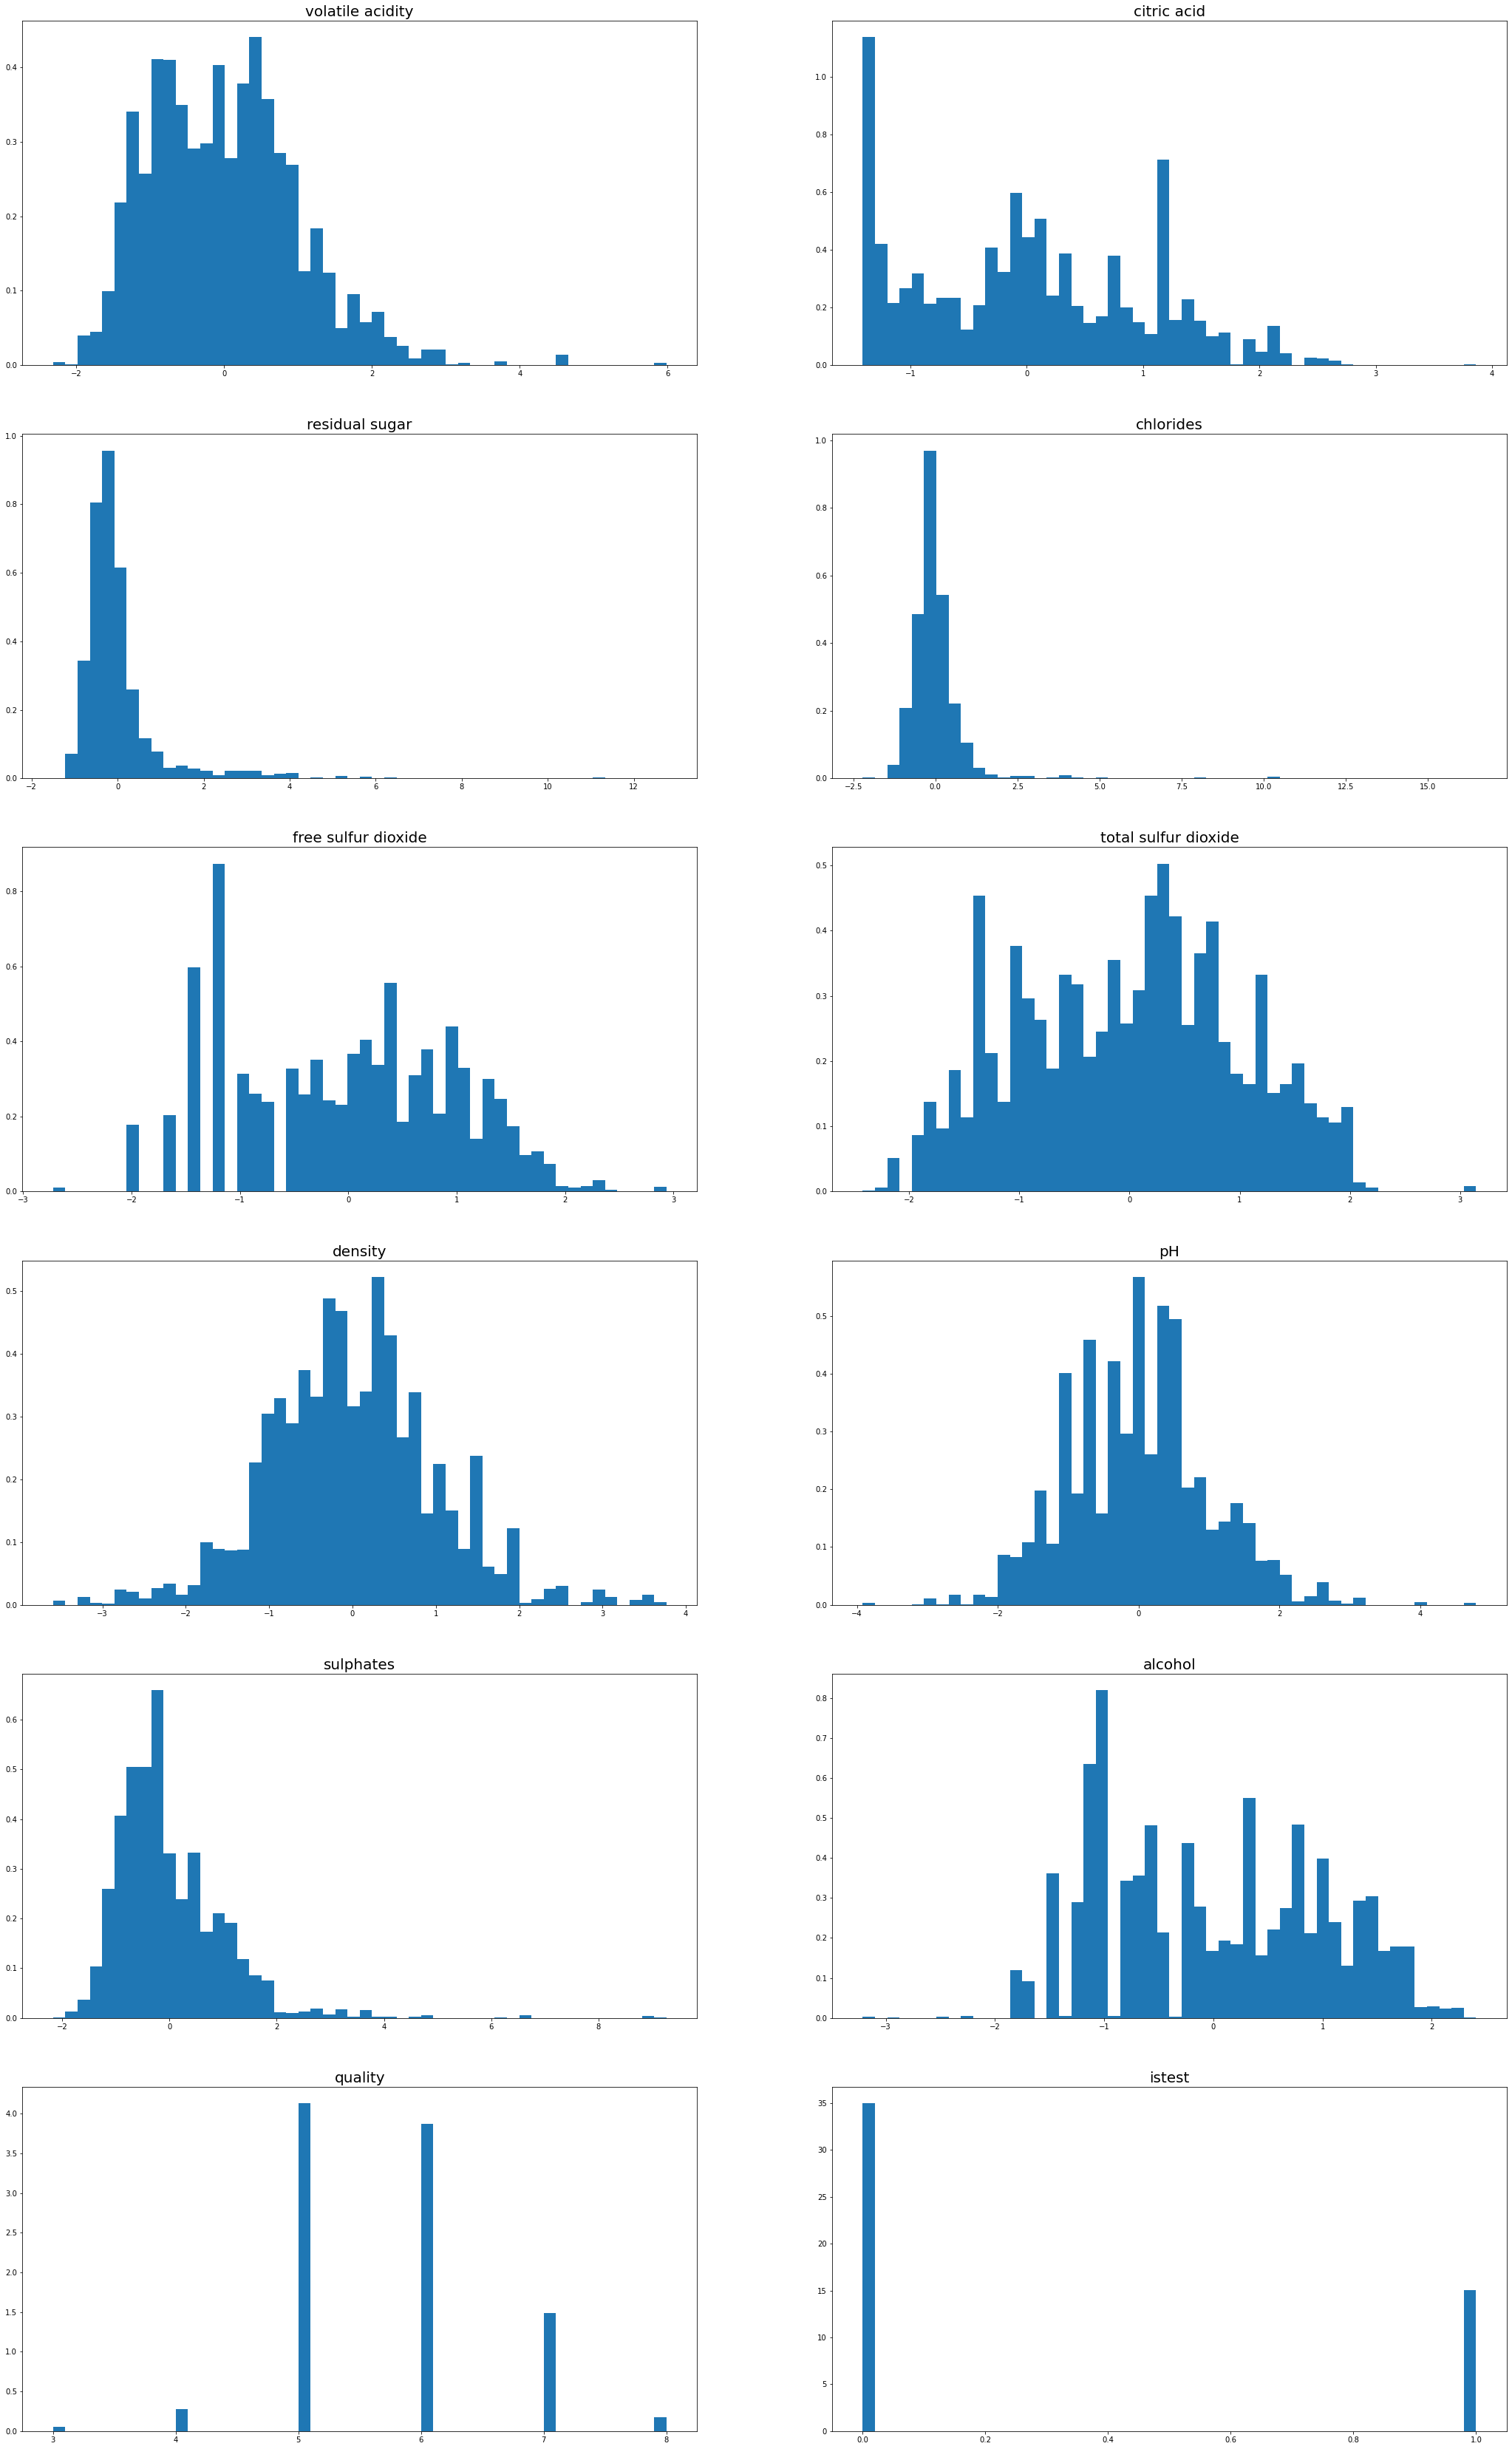

In [14]:
pt = PowerTransformer()
for f in ['fixed acidity', 'alcohol', 'total sulfur dioxide', 'free sulfur dioxide']:
    raw[f] = pt.fit_transform(np.array(raw[f]).reshape(-1,1))
    
scaler = preprocessing.StandardScaler()
for f in features:
    raw[f] = scaler.fit_transform(np.array(raw[f]).reshape(-1, 1))
    
tmp = list(train.columns[1:])
fig, axs = plt.subplots(6, 2)
fig.set_size_inches(36, 60)
for r in range(6):
    for c in range(2):
        axs[r, c].hist(raw[tmp[2*r+c]], bins=50, density=True, log=False)
        axs[r, c].set_title(f'{tmp[2*r+c]}', fontsize=20)

### Now those look better. 
### However, let us hardcode and remove certain obvious outliers from the columns [volatie acidity, residual sugar, chlorides, sulphates, pH and density]
### One thing I learnt throughout my machine learning journey is that if you don't care for the outliers, your model would be seriously undermined.
### Before we forcefully remove these 'outliers', let us first see whether there could potentially be any undesirable consequences.

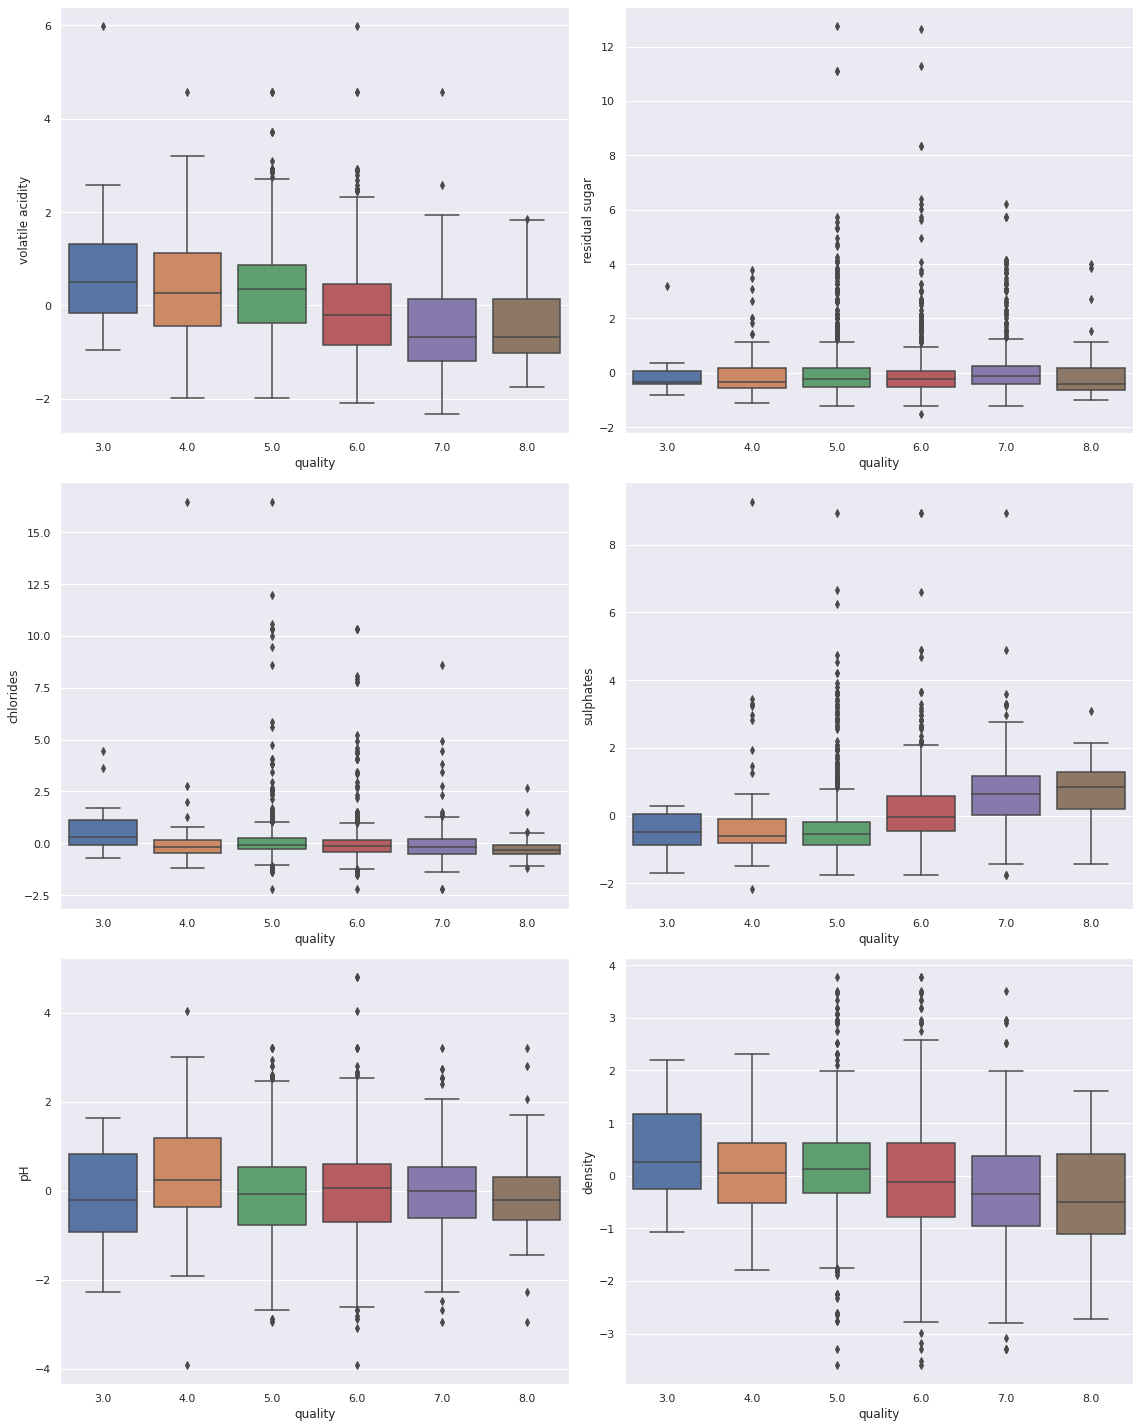

In [15]:
outlier_col = ['volatile acidity', 'residual sugar', 'chlorides', 'sulphates', 'pH', 'density']

sns.set(rc={'figure.figsize':(16, 20)})
fig, axs = plt.subplots(nrows = 3, ncols=2)
for r in range(3):
    for c in range(2):
        sns.boxplot(x=target,y=outlier_col[r*2+c], data=raw[raw.istest==0], ax=axs[r][c])
        
plt.tight_layout()
plt.show()

### The classes of 5 and 6 seem to have most of the outliers. 
### It might not be a good idea to remove these outliers as they may result in a severe unbalancing of our target variables. 
### However, in this scenario, we would only be removing a few and the 'quality' distribution for 5 and 6 is the greatest. 
### Thus I believe the forceful removal of these outliers will affect our code way too much.

In [16]:
volatile_acidity_invalid_idx = (raw.istest == 0) & (raw['volatile acidity'] > 2.3)
residual_sugar_invalid_idx = (raw.istest == 0) & (raw['residual sugar'] > 2)
chlorides_invalid_idx = (raw.istest == 0) & (raw['chlorides'] > 2.5)
sulphates_invalid_idx = (raw.istest == 0) & (raw['sulphates'] > 2.6)
pH_invalid_idx = (raw.istest == 0) & (raw['pH']>2.4) & (raw['pH'] < -3)
density_invalid_idx = (raw.istest == 0) & (raw.density > 2.5) & (raw.density < -2.5)

In [17]:
total_removed_cnt = len(volatile_acidity_invalid_idx[volatile_acidity_invalid_idx==True]) + len(residual_sugar_invalid_idx[residual_sugar_invalid_idx==True]) + len(chlorides_invalid_idx[chlorides_invalid_idx==True]) + len(sulphates_invalid_idx[sulphates_invalid_idx==True]) + len(pH_invalid_idx[pH_invalid_idx==True]) + len(density_invalid_idx[density_invalid_idx==True]) 
print(f"Total number of rows removed from the train dataset is {total_removed_cnt}, {total_removed_cnt/len(train)*100}% of the whole dataset")

Total number of rows removed from the train dataset is 351, 17.071984435797667% of the whole dataset


### As outliers, we removed about 17% of the train dataset and we would use the remaining scaled 83% of the train dataset to choose our model.

# Feature Engineering

### As we have completed feature adjustments, let us see whether there is any possible features we can possibly engineer from the available columns.

In [18]:
raw['total_acid'] = raw['fixed acidity'] + raw['volatile acidity'] + raw['citric acid']
raw['acid/density'] = raw['total_acid']  / raw['density']
raw['alcohol_density'] = raw['alcohol']  * raw['density']
raw['sulphate/density'] = raw['sulphates']  / raw['density']
raw['sulphates/acid'] = raw['sulphates'] / raw['volatile acidity']
raw['sulphates/chlorides'] = raw['sulphates'] / raw['chlorides']
raw['sulphates*alcohol'] = raw['sulphates'] / raw['alcohol']

In [19]:
additional_columns = ['total_acid', 'acid/density', 'alcohol_density', 'sulphate/density', 'sulphates/acid', 'sulphates/chlorides', 'sulphates*alcohol']

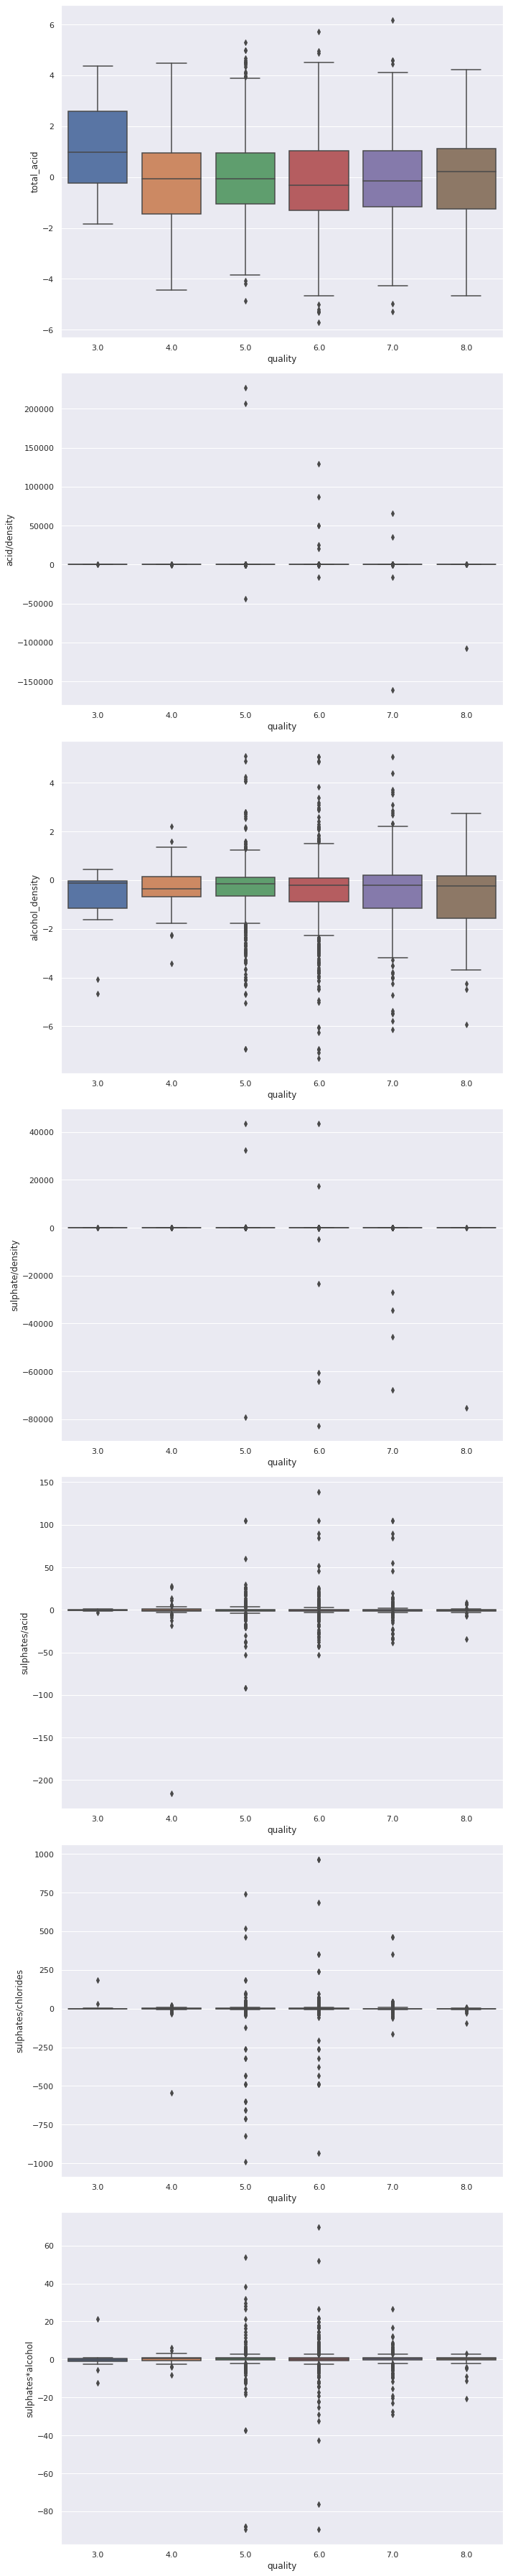

In [20]:
sns.set(rc={'figure.figsize':(10, 50)})
fig, axs = plt.subplots(nrows = 7)
for r in range(7):
    sns.boxplot(x=target,y=additional_columns[r], data=raw, ax=axs[r])
        
plt.tight_layout()
plt.show()

### It seems to me that the two features with high variations - alcohol_density and total_acid seems to be beneficial.
### Let us include them to our features list.
### Let us take a look at the correlation heatmap to see if there are any other significant relationships we can salvage.

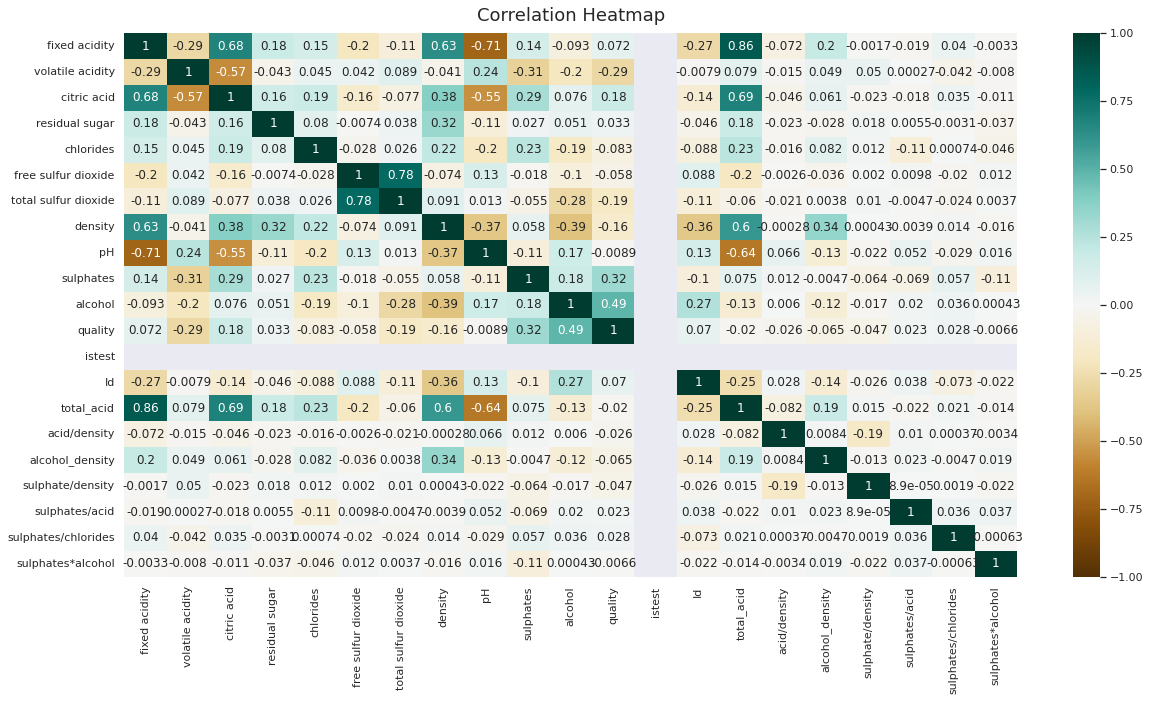

In [21]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(raw[raw.istest==0].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

### Well, from this heatmap, I was able to gather that alcohol and sulphates seem to have the greatest predictable (linear) influence on the target variable but the others were almost insignificant. 
### However, I see that volatile_acidity and total_sulfur_dioxide shows some negative relationship with our target variable, so I will proceed to multiply them together and form a feature.

In [22]:
raw['volatile_acidity*total_sulfur_dioxide'] = raw['volatile acidity'] * raw['total sulfur dioxide']

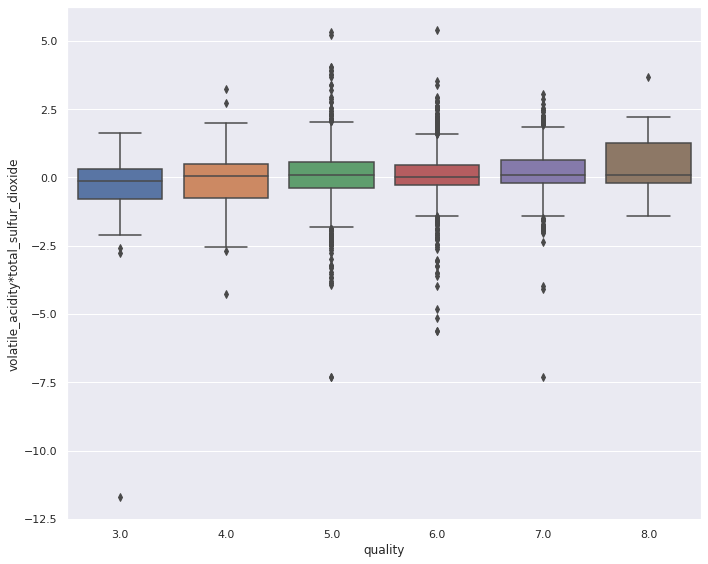

In [23]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.boxplot(x=target,y='volatile_acidity*total_sulfur_dioxide', data=raw)
plt.tight_layout()

### Now I think this is not a very informative feature and would add noise to our model.
### I will choose not to include this feature into our overall feature list. 

In [24]:
features += ['alcohol_density', 'total_acid']

# Modeling

### Now, let us start to play around with various models shall we?


In [25]:
encoder = LabelEncoder()
raw[target] = encoder.fit_transform(raw[target])

In [26]:
raw_train = raw.copy()
raw_train = raw_train[raw_train['istest'] == 0]

# Code to remove outliers (have to see whether there is an improvement in result)
raw_train = raw_train[raw_train['volatile acidity'] < 2.3]
raw_train = raw_train[raw_train['residual sugar'] < 2]
raw_train = raw_train[raw_train['chlorides'] < 2.5]
raw_train = raw_train[raw_train['sulphates'] < 2.6]
raw_train = raw_train[raw_train['pH'] < 2.4]
raw_train = raw_train[raw_train['pH'] > -3]
raw_train = raw_train[raw_train['density'] < 2.5]
raw_train = raw_train[raw_train['density'] > -2.5]

In [27]:
# Testing the benchmark approach (with untouched dataset)

train = raw_train
test = raw[raw.istest == 1]

RANDOM = 12

### LGBMClassifier

In [28]:
lgb_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss'
}

lgb_predictions = []
lgb_scores = []
lgb_fimp = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    
    preds_valid = model.predict(X_valid)
    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")
    lgb_scores.append(score)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, Quadratic Kappa Metric score: {score:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=features,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    test_preds = model.predict(test[features])
    lgb_predictions.append(test_preds)
    
print("Mean Score :", np.mean(lgb_scores))

# 0.458596

========== Fold=1 ==========
Fold=1, Quadratic Kappa Metric score: 0.52, Run Time: 0.90s
========== Fold=2 ==========
Fold=2, Quadratic Kappa Metric score: 0.47, Run Time: 0.70s
========== Fold=3 ==========
Fold=3, Quadratic Kappa Metric score: 0.54, Run Time: 0.71s
========== Fold=4 ==========
Fold=4, Quadratic Kappa Metric score: 0.49, Run Time: 0.71s
========== Fold=5 ==========
Fold=5, Quadratic Kappa Metric score: 0.56, Run Time: 0.71s
Mean Score : 0.515717551053107


### CatBoostClassifier

In [29]:
catb_params = {
    "objective": "MultiClass",
    "loss_function" : "WKappa",
    "random_seed": 12
}


catb_predictions = []
catb_scores = []
catb_fimp = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]
    
    model = CatBoostClassifier(**catb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    preds_valid = model.predict(X_valid)
    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")
    catb_scores.append(score)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, Quadratic Kappa Metric score: {score:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=features,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    catb_fimp.append(fim)
    test_preds = model.predict(test[features])
    catb_predictions.append(test_preds)
    
print("Mean Score :", np.mean(catb_scores))

========== Fold=1 ==========
Fold=1, Quadratic Kappa Metric score: 0.55, Run Time: 5.96s
========== Fold=2 ==========
Fold=2, Quadratic Kappa Metric score: 0.51, Run Time: 5.87s
========== Fold=3 ==========
Fold=3, Quadratic Kappa Metric score: 0.56, Run Time: 5.82s
========== Fold=4 ==========
Fold=4, Quadratic Kappa Metric score: 0.51, Run Time: 6.14s
========== Fold=5 ==========
Fold=5, Quadratic Kappa Metric score: 0.55, Run Time: 5.77s
Mean Score : 0.5341037119379085


### XGBClassifier

In [30]:
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss'
}


xgb_predictions = []
xgb_scores = []
xgb_fimp = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]
    
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")
    xgb_scores.append(score)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, Quadratic Kappa Metric score : {score:.2f}, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[features])
    fim = pd.DataFrame(index=features,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    xgb_fimp.append(fim)
    xgb_predictions.append(test_preds)
    
print("Mean Score :", np.mean(xgb_scores))

========== Fold=1 ==========
Fold=1, Quadratic Kappa Metric score : 0.52, Run Time: 1.43s
========== Fold=2 ==========
Fold=2, Quadratic Kappa Metric score : 0.49, Run Time: 1.39s
========== Fold=3 ==========
Fold=3, Quadratic Kappa Metric score : 0.55, Run Time: 1.52s
========== Fold=4 ==========
Fold=4, Quadratic Kappa Metric score : 0.48, Run Time: 1.47s
========== Fold=5 ==========
Fold=5, Quadratic Kappa Metric score : 0.52, Run Time: 1.45s
Mean Score : 0.5101136840485442


# Hyperparameter Tuning

### Since the catboost classifier shows the most promise, let's try to tune that model.
* This will show us the best parameters of each models for us to utilize below

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.33, random_state=RANDOM)

In [32]:
"""def objective(trial):        
    params_optuna = {
        'iterations':trial.suggest_int("iterations", 10, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10, step = 1),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50)
        }

        
    n=trial.suggest_int('n_cv', 3, 5)
    cv = StratifiedKFold(n,shuffle=True, random_state=RANDOM)
    fold_scores = []
    for i, (train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, X_val = train.iloc[train_idx][features], train.iloc[valid_idx][features]
        y_train , y_val = train[target].iloc[train_idx] , train[target].iloc[valid_idx]

        model = CatBoostClassifier(**params_optuna)
        model.fit(X_train,
                 y_train,
                 eval_set= [(X_val,y_val)],
                 early_stopping_rounds = 50,
                 verbose=500)

        pred_val = model.predict(X_val)
        pred_test = model.predict(test[features])

        score = cohen_kappa_score(y_val,pred_val)
        fold_scores.append(score)
    return np.mean(fold_scores)

study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(func=objective, n_trials=100)
study.best_params"""

'def objective(trial):        \n    params_optuna = {\n        \'iterations\':trial.suggest_int("iterations", 10, 1000),\n        \'learning_rate\':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),\n        \'depth\':trial.suggest_int("depth", 4, 10, step = 1),\n        \'l2_leaf_reg\':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),\n        \'bootstrap_type\':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),\n        \'random_strength\':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),\n        \'bagging_temperature\':trial.suggest_float("bagging_temperature", 0.0, 10.0),\n        \'od_type\':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),\n        \'od_wait\':trial.suggest_int("od_wait", 10, 50)\n        }\n\n        \n    n=trial.suggest_int(\'n_cv\', 3, 5)\n    cv = StratifiedKFold(n,shuffle=True, random_state=RANDOM)\n    fold_scores = []\n    for i, (train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):\n  

In [33]:
"""def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 10, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10, step = 1),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
        # task_type= "GPU"
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return cohen_kappa_score(y_test, y_pred, weights = "quadratic")

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler, pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=100)

#------------------------------------------------------------#

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))"""

'def objective(trial):\n    model = CatBoostClassifier(\n        iterations=trial.suggest_int("iterations", 10, 1000),\n        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),\n        depth=trial.suggest_int("depth", 4, 10, step = 1),\n        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),\n        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),\n        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),\n        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),\n        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),\n        od_wait=trial.suggest_int("od_wait", 10, 50),\n        verbose=False\n        # task_type= "GPU"\n    )\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    return cohen_kappa_score(y_test, y_pred, weights = "quadratic")\n\noptuna.logging.set_verbosity(optuna.logging.WARNING)\n\nsampler = TPESamp

In [34]:
"""catb_predictions = []
catb_scores = []
catb_fimp = []

params = {'iterations': 884,
 'learning_rate': 0.026508587549520953,
 'depth': 8,
 'l2_leaf_reg': 5.1902304600116915e-08,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.7401444204250995,
 'bagging_temperature': 9.82297935339484,
 'od_type': 'IncToDec',
 'od_wait': 39
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]
    
    model = CatBoostClassifier(**params, verbose=False)
    model.fit(X_train, y_train, verbose = 0)
    
    preds_valid = model.predict(X_valid)
    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")
    catb_scores.append(score)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, Quadratic Kappa Metric score: {score:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=features,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    catb_fimp.append(fim)
    test_preds = model.predict(test[features])
    catb_predictions.append(test_preds)
    
print("Mean Score :", np.mean(catb_scores))"""

'catb_predictions = []\ncatb_scores = []\ncatb_fimp = []\n\nparams = {\'iterations\': 884,\n \'learning_rate\': 0.026508587549520953,\n \'depth\': 8,\n \'l2_leaf_reg\': 5.1902304600116915e-08,\n \'bootstrap_type\': \'Bayesian\',\n \'random_strength\': 1.7401444204250995,\n \'bagging_temperature\': 9.82297935339484,\n \'od_type\': \'IncToDec\',\n \'od_wait\': 39\n}\n\nskf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM)\nfor fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):\n    \n    print(10*"=", f"Fold={fold+1}", 10*"=")\n    start_time = time.time()\n    \n    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]\n    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]\n    \n    model = CatBoostClassifier(**params, verbose=False)\n    model.fit(X_train, y_train, verbose = 0)\n    \n    preds_valid = model.predict(X_valid)\n    score = cohen_kappa_score(y_valid,  preds_va

### Let's try tuning for our XGBClassifier

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.33, random_state=RANDOM)

In [36]:
"""def objective(trial):
    params = {
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.01, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1.0),
            'objective' : " multi:softmax",
        }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return cohen_kappa_score(y_test, y_pred, weights = "quadratic")

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="xgboost", direction="maximize", sampler=sampler, pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=100)

#------------------------------------------------------------#

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))"""

'def objective(trial):\n    params = {\n            \'max_depth\': trial.suggest_int(\'max_depth\', 1, 10),\n            \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 1.0),\n            \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 1000),\n            \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n            \'gamma\': trial.suggest_float(\'gamma\', 0.01, 1.0),\n            \'subsample\': trial.suggest_float(\'subsample\', 0.5, 1.0),\n            \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.5, 1.0),\n            \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0.0001, 1.0),\n            \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.0001, 1.0),\n            \'objective\' : " multi:softmax",\n        }\n    model = XGBClassifier(**params)\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    return cohen_kappa_score(y_test, y_pred, weights = "quadratic")\n\noptuna.logging.set_verbosit

In [37]:
"""xgb_predictions = []
xgb_scores = []
xgb_fimp = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]
    
    model = XGBClassifier(**trial.params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")
    xgb_scores.append(score)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, Quadratic Kappa Metric score : {score:.2f}, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[features])
    fim = pd.DataFrame(index=features,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    xgb_fimp.append(fim)
    xgb_predictions.append(test_preds)
    
print("Mean Score :", np.mean(xgb_scores))"""

'xgb_predictions = []\nxgb_scores = []\nxgb_fimp = []\n\nskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)\nfor fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):\n    \n    print(10*"=", f"Fold={fold+1}", 10*"=")\n    start_time = time.time()\n    \n    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]\n    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]\n    \n    model = XGBClassifier(**trial.params)\n    model.fit(X_train, y_train,verbose=0)\n    \n    preds_valid = model.predict(X_valid)\n    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")\n    xgb_scores.append(score)\n    run_time = time.time() - start_time\n    \n    print(f"Fold={fold+1}, Quadratic Kappa Metric score : {score:.2f}, Run Time: {run_time:.2f}s")\n    test_preds = model.predict(test[features])\n    fim = pd.DataFrame(index=features,\n                 data=model.feature_i

### Now, let us attempt to tune the LGBMClassifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.33, random_state=RANDOM)

In [39]:
""" def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 200, step=1, log=True), 
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 8, 1024, step=1, log=True), 
        'objective': 'multiclass', 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'random_state': RANDOM
        # 'device': 'gpu'
    }
    
    model = LGBMClassifier(**params, verbose = -1)    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return cohen_kappa_score(y_test, y_pred, weights = "quadratic")

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler, pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=100)

#------------------------------------------------------------#

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))"""

' def objective(trial):\n    params = {\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 2, 200, step=1, log=True), \n        \'max_depth\': trial.suggest_int(\'max_depth\', 1, 10, step=1, log=False), \n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.0001, 0.1, log=True), \n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 8, 1024, step=1, log=True), \n        \'objective\': \'multiclass\', \n        \'class_weight\': trial.suggest_categorical(\'class_weight\', [\'balanced\', None]),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 10, 50, step=1, log=False), \n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.7, 1.0), \n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.7, 1.0),\n        \'reg_alpha\': trial.suggest_uniform(\'reg_alpha\', 0.0, 1.0),\n        \'reg_lambda\': trial.suggest_uniform(\'reg_lambda\', 0.0, 10.0),\n        \'random_state\': RANDOM\n        # \'device\': \'gp

In [40]:
"""lgb_predictions = []
lgb_scores = []
lgb_fimp = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]
    
    model = LGBMClassifier(**trial.params, verbose = -1)
    model.fit(X_train, y_train)
    
    preds_valid = model.predict(X_valid)
    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")
    lgb_scores.append(score)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, Quadratic Kappa Metric score: {score:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=features,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    test_preds = model.predict(test[features])
    lgb_predictions.append(test_preds)
    
print("Mean Score :", np.mean(lgb_scores))"""

'lgb_predictions = []\nlgb_scores = []\nlgb_fimp = []\n\nskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)\nfor fold, (train_idx, valid_idx) in enumerate(skf.split(train[features], train[target])):\n    \n    print(10*"=", f"Fold={fold+1}", 10*"=")\n    start_time = time.time()\n    \n    X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]\n    y_train , y_valid = train[target].iloc[train_idx] , train[target].iloc[valid_idx]\n    \n    model = LGBMClassifier(**trial.params, verbose = -1)\n    model.fit(X_train, y_train)\n    \n    preds_valid = model.predict(X_valid)\n    score = cohen_kappa_score(y_valid,  preds_valid, weights = "quadratic")\n    lgb_scores.append(score)\n    run_time = time.time() - start_time\n    \n    print(f"Fold={fold+1}, Quadratic Kappa Metric score: {score:.2f}, Run Time: {run_time:.2f}s")\n    fim = pd.DataFrame(index=features,\n                 data=model.feature_importances_,\n                 columns=[f\'{

### Again

In [41]:
k=10
cv = StratifiedKFold(k, shuffle=True, random_state=42)
fold_scores = []
test_preds = []
oof_preds = []
oof_true = []

for i, (train_idx,val_idx) in enumerate(cv.split(train[features],
                                                 train[target])):
    
    X_train, X_val = train.iloc[train_idx][features], train.iloc[val_idx][features]
    y_train , y_val = train[target].iloc[train_idx] , train[target].iloc[val_idx]
    
    #************** cat **************
    
    params_cat = {'iterations': 837,
        'learning_rate': 0.002669474431907143,
        'depth': 9,
        'l2_leaf_reg': 5.472638253931108e-06,
        'bootstrap_type': 'Bayesian',
        'random_strength': 0.005468081398327989,
        'bagging_temperature': 1.3063353495735732,
        'od_type': 'IncToDec',
        'od_wait': 16
    }
    
    model1 = CatBoostClassifier(**params_cat)
    model1.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=200)
    
    pred_val1 = model1.predict(X_val)
    
    score1 = cohen_kappa_score(y_val,pred_val1)
    #discard the predictions of poor performing models
    if score1>0.36:
        test_preds.append(model1.predict(test[features]))
        fold_scores.append(score1)
    
    #************** Light GBM **************
    
    params_xgb = {'max_depth': 4,
    'learning_rate': 0.14878804376299942,
    'n_estimators': 802,
    'min_child_weight': 7,
    'gamma': 0.6864337739662847,
    'subsample': 0.9564080108958588,
    'colsample_bytree': 0.6634959310704276,
    'reg_alpha': 0.9189366983637447,
    'reg_lambda': 0.7804966134962386
                  }
    
    model2 = XGBClassifier(**params_xgb)
    model2.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=200)
    
    pred_val2 = model2.predict(X_val)
    
    score2 = cohen_kappa_score(y_val,pred_val2)
    #discard the predictions of poor performing models
    if score2>0.36:
        test_preds.append(model2.predict(test[features]))
        fold_scores.append(score2)
    
    oof_preds.extend(np.mean([pred_val1.flatten(),pred_val2],axis=0))
    oof_true.extend(y_val)
    print(f'=== Fold {i} Cohen Kappa Score {np.mean([score1,score2])} ===')

print(f'=== Average Cohen Kappa Score {np.mean(fold_scores)} ===')

0:	learn: 1.7862166	test: 1.7872733	best: 1.7872733 (0)	total: 47.1ms	remaining: 39.4s
200:	learn: 1.1321620	test: 1.3160737	best: 1.3160737 (200)	total: 6.29s	remaining: 19.9s
400:	learn: 0.8572590	test: 1.1533315	best: 1.1533315 (400)	total: 12.3s	remaining: 13.4s
600:	learn: 0.6990887	test: 1.0774787	best: 1.0774787 (600)	total: 18.7s	remaining: 7.35s
800:	learn: 0.5958632	test: 1.0413348	best: 1.0413348 (800)	total: 24.8s	remaining: 1.11s
836:	learn: 0.5807422	test: 1.0373449	best: 1.0373449 (836)	total: 25.9s	remaining: 0us

bestTest = 1.037344863
bestIteration = 836

[0]	validation_0-mlogloss:1.65549
[200]	validation_0-mlogloss:1.06158
[241]	validation_0-mlogloss:1.07097
=== Fold 0 Cohen Kappa Score 0.29598760457516915 ===
0:	learn: 1.7857210	test: 1.7868389	best: 1.7868389 (0)	total: 30.4ms	remaining: 25.4s
200:	learn: 1.1385259	test: 1.2680847	best: 1.2680847 (200)	total: 6.24s	remaining: 19.8s
400:	learn: 0.8645982	test: 1.0804631	best: 1.0804631 (400)	total: 12.3s	remaining: 

# Threshold Tuning

In [42]:
class OptunaRounder:

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = np.unique(y_true)

    def __call__(self, trial):
        thresholds = []
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
        except: return 0
        return cohen_kappa_score(self.y_true, opt_y_pred, weights='quadratic')

    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred,
                            [-np.inf] + thresholds + [np.inf],
                            labels=self.labels)
        return opt_y_pred

In [43]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
objective = OptunaRounder(oof_true, oof_preds)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM))
study.optimize(objective, timeout=100)

In [44]:
# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
print(f'Optimized thresholds: {best_thresholds}')

oof_pred_opt = objective.adjust(oof_preds, best_thresholds)
best_score = cohen_kappa_score(oof_true, oof_pred_opt, weights='quadratic')
print(f'Optimized OOF Score: {best_score:.5f}')

Optimized thresholds: [0.11660217528652139, 1.776750490785291, 2.9597514795254245, 3.077304838057504, 3.7530775025885035]
Optimized OOF Score: 0.53952


# Feature Importances of catboost

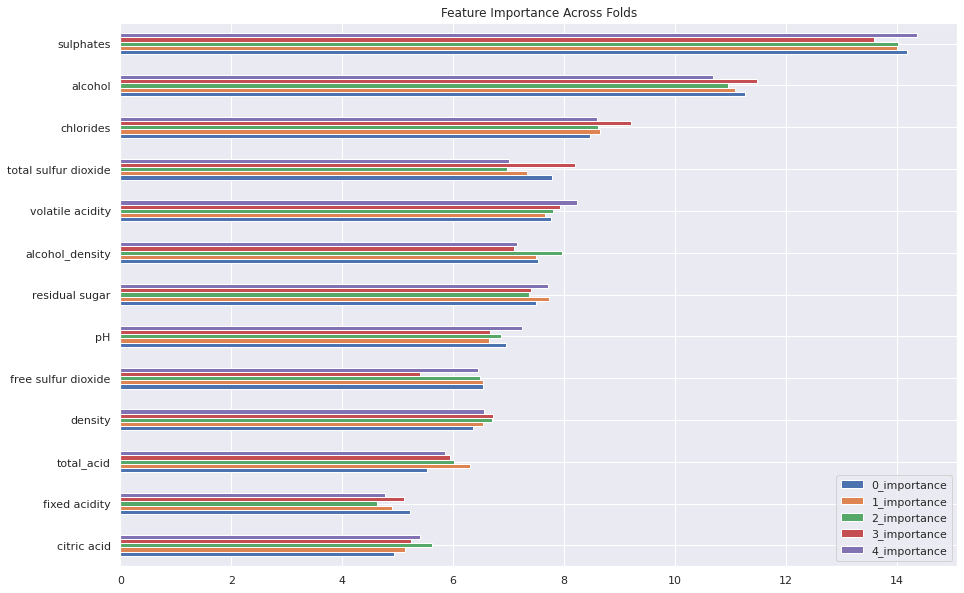

In [45]:
catb_fis_df = pd.concat(catb_fimp, axis=1).head(15)
catb_fis_df.sort_values('0_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
plt.show()

# Submission

In [46]:
"""lgb_pred = encoder.inverse_transform(np.squeeze(mode(np.column_stack(lgb_predictions),axis = 1)[0]).astype('int'))
cat_pred = encoder.inverse_transform(np.squeeze(mode(np.column_stack(catb_predictions),axis = 1)[0]).astype('int'))
xgb_pred = encoder.inverse_transform(np.squeeze(mode(np.column_stack(xgb_predictions),axis = 1)[0]).astype('int'))"""

"lgb_pred = encoder.inverse_transform(np.squeeze(mode(np.column_stack(lgb_predictions),axis = 1)[0]).astype('int'))\ncat_pred = encoder.inverse_transform(np.squeeze(mode(np.column_stack(catb_predictions),axis = 1)[0]).astype('int'))\nxgb_pred = encoder.inverse_transform(np.squeeze(mode(np.column_stack(xgb_predictions),axis = 1)[0]).astype('int'))"

### Ensembling

In [47]:
"""np.squeeze(mode(np.column_stack([lgb_pred,cat_pred]),axis = 1)[0])"""

'np.squeeze(mode(np.column_stack([lgb_pred,cat_pred]),axis = 1)[0])'

In [48]:
for i in range(len(test_preds)):
    test_preds[i] = test_preds[i].flatten()
test_preds = np.array(test_preds).mean(axis=0) 
opt_test_preds = objective.adjust(test_preds, best_thresholds).astype(int) +3
sub[target] = opt_test_preds
sub.to_csv('submission.csv', index=False)

In [49]:
sub.quality.value_counts()

5    709
6    407
7    177
8     79
Name: quality, dtype: int64

In [50]:
"""catb_submission = sub.copy()
catb_submission[target] = cat_pred.astype(int)
catb_submission.to_csv("submission.csv",index=False)
catb_submission.head()"""

'catb_submission = sub.copy()\ncatb_submission[target] = cat_pred.astype(int)\ncatb_submission.to_csv("submission.csv",index=False)\ncatb_submission.head()'